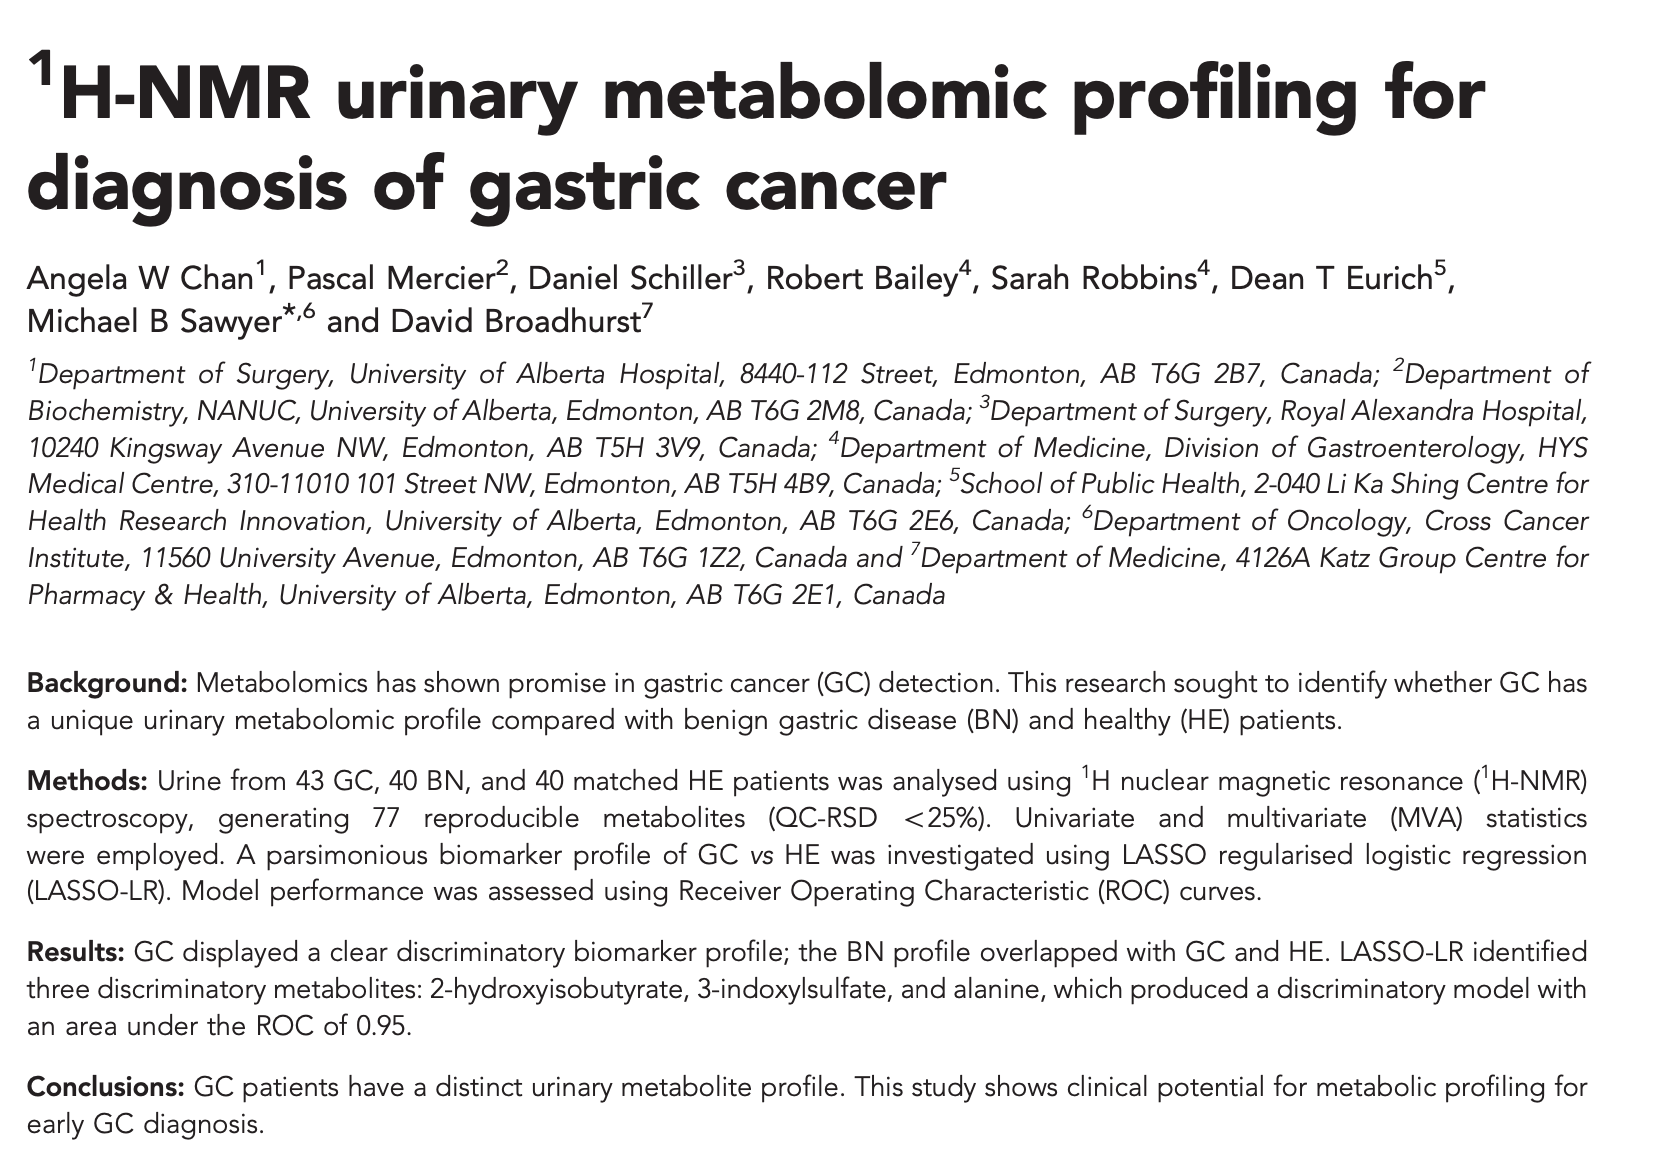

* conda create -n MetabWorkflowTutorial python=3.7.3

* conda activate MetabWorkflowTutorial

* conda config --add channels cimcb # esencial

* conda config --add channels conda-forge # esencial

* conda config --add channels defaults # esencial

* conda config --add channels bioconda # opcional

**Packages:**

* conda install pandas=0.24.2

* conda install numpy=1.16.3

* conda install bokeh=1.1.0

* conda install Jinja2==3.0.3

* conda install xlrd=1.2.0

* conda install openpyxl=2.6.1

* conda install cimcb_lite=1.0.3

**Aditionals (si te hace falta), si ya los tienes integrados en visual code no hace (falta) solo activa el ambiente MetabWorkflowTutorial y acepta la instalación del kernel:**

* conda install jupyter=1.0

* conda install notebook=6.4.7


<div style="background-color:rgb(255, 250, 250); padding:5px; padding-left: 1em; padding-right: 1em;">


<h1 id="tuturial1 flujo de trabajo básico de análisis de datos metabolómicos" style="text-align: justify">Tutorial 1: Flujo de trabajo básico de análisis de datos metabolómicos</h1>

<p><br>
<br>
<br>
<br>

<p  style="text-align: justify">Este cuaderno Jupyter describe un flujo de trabajo típico de análisis de datos metabolómicos para un estudio con un resultado de clasificación binario. Los principales pasos incluidos son: </p>

<ul>
<li style="text-align: justify">Importar metabolito &amp; datos experimentales de una hoja Excel. </li>

<li style="text-align: justify">Limpieza de datos basada en el QC agrupado.</li>

<li style="text-align: justify">Visualización del análisis de componentes principales para comprobar la calidad de los datos.</li>

<li style="text-align: justify">Estadística univariante de dos clases.</li>

<li style="text-align: justify">Análisis multivariante mediante análisis discriminante de mínimos cuadrados parciales (PLS-DA), que incluye:


<ul>
<li style="text-align: justify">optimización de modelos (R<sup>2</sup> vs Q<sup>2</sup>).</li>

<li style="text-align: justify">pruebas de permutación, métricas de predicción de modelos.</li>

<li style="text-align: justify">importancia de las características.</li>

<li style="text-align: justify">visualizaciones de datos de predicción de modelos.</li></ul>
</li>

<li style="text-align: justify">Exporte tablas estadísticas a hojas Excel.</li>
</ul>

<p style="text-align: justify">El estudio utilizado en este tutorial se encuentra publicado como artículo de acceso abierto <a href="https://www.nature.com/articles/bjc2015414">Chan et al. (2016)</a>, in the British Journal of Cancer, y el archivo de datos deconvolved y anotado depositado en el <a href="http://www.metabolomicsworkbench.org">Metabolomics Workbench data repository</a> (Project ID PR000699). Se puede acceder a los datos directamente a través de su proyecto <a href="http://dx.doi.org/DOI:10.21228/M8B10B">DOI:10.21228/M8B10B</a> <sup>1</sup>H-NMR spectra were acquired at Canada’s National High Field Nuclear Magnetic Resonance Centre (NANUC) using a 600 MHz Varian Inova spectrometer. La deconvolución espectral y la anotación de metabolitos se realizaron mediante el programa <a href="https://www.chenomx.com/software/">Chenomx NMR Suite v7.6</a>. Desafortunadamente, los datos de RMN en bruto no están disponibles.</p>

</div>

<div style="background-color:rgb(255, 250, 250); padding:5px; padding-left: 1em; padding-right: 1em;">
    
<h2 id="1importpackagesmodules" style="text-align: justify">1. Importar paquetes/módulos</h2>

<p style="text-align: justify">La primera celda de código de este tutorial (debajo de este cuadro de texto) importa <a href="https://docs.python.org/3/tutorial/modules.html"><em>packages</em> y <em>modules</em></a> en el entorno Jupyter. <em>Packages</em> y <em>modules</em> proporcionan funciones y herramientas adicionales que amplían la funcionalidad básica del lenguaje Python. Necesitaremos las siguientes herramientas para analizar los datos de este tutorial:<br></p>

<ul>
<li style="text-align: justify"><a href="http://www.numpy.org/"><code>numpy</code></a>: el paquete fundamental para la computación científica con Python, que proporciona herramientas para trabajar con matrices y álgebra lineal.</li>

<li style="text-align: justify"><a href="https://pandas.pydata.org/"><code>pandas</code></a>: proporciona estructuras de datos y herramientas de análisis de datos de alto rendimiento y fáciles de usar</li>

<li style="text-align: justify"><a href="https://scikit-learn.org/stable/"><code>sklearn</code></a>: herramientas de aprendizaje automático en Python


<ul>
<li style="text-align: justify"><a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html"><code>train_test_split</code></a>: Un método para dividir matrices en subconjuntos aleatorios de prueba/entrenamiento para validación cruzada (cross-validation).</li></ul>
</li>

<li style="text-align: justify"><a href="https://github.com/KevinMMendez/cimcb_lite"><code>cimcb_lite</code></a>: una librería de funciones útiles proporcionadas por los autores.</li>
</ul>

<p style="text-align: justify"><strong>Ejecuta la celda haciendo clic en cualquier lugar de la celda (la celda estará rodeada por un recuadro azul) y, a continuación, haciendo clic en <kbd>Run</kbd> in the Menu.</strong> <br>
When successfully executed the cell will print <code>All packages successfully loaded</code> in the notebook below the cell.</p>
</div>

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import cimcb_lite as cb

print('All packages successfully loaded')

All packages successfully loaded


<div style="background-color:rgb(255, 250, 250); padding:5px; padding-left: 1em; padding-right: 1em;">
    
<h2 id="2loaddataandpeaksheet" style="text-align: justify">2. Datos de carga y hoja de picos (Peaks)</h2>

<p style="text-align: justify">Este flujo de trabajo requiere que los datos se carguen como un archivo de Microsoft Excel, utilizando la función <a href="https://en.wikipedia.org/wiki/Tidy_data">Tidy Data</a> marco (es decir, cada columna es una variable y cada fila es una observación). Como tal, el archivo Excel debe contener un <em>Data Sheet</em> y <em>Peak Sheet</em>. El <em>Data Sheet</em> contiene todas las concentraciones de metabolitos y los metadatos asociados a cada observación (lo que requiere la inclusión de las columnas: <em>Idx</em>, <em>SampleID</em>, and <em>Class</em>). El <em>Peak Sheet</em> contiene todos los metadatos relativos a cada metabolito medido (lo que requiere la inclusión de las columnas: <em>Idx</em>, <em>Name</em>, and <em>Label</em>). Inspecciona el <a href="GastricCancer_NMR.xlsx">Excel file</a> utilizado en este tutorial antes de continuar. </p>

<p style="text-align: justify">La celda de código siguiente carga el <em>Data</em> and <em>Peak</em> hojas de un fichero Excel, utilizando la función de ayuda CIMCB <code>load_dataXL()</code>. Cuando haya terminado, deberías ver la confirmación de que Peak (almacenados en la carpeta <code>Peak</code> en el archivo Excel) y Datos (almacenados en el archivo <code>Data</code> en el archivo Excel) se han cargado las tablas:</p>

<pre style="text-align: justify"><code class="text language-text">Carga PeakFile: Peak
Cargas ArchivoDeDatos: Datos
Tabla de datos &amp; La tabla Peak es adecuada.
TOTAL MUESTRAS: 140 TOTAL PEAKS: 149
Done!
</code></pre>

<p style="text-align: justify">Una vez cargados, los datos están disponibles para su uso en <a href="https://swcarpentry.github.io/python-novice-gapminder/02-variables/"><em>variables</em></a> denominado <code>dataTable</code> and <code>peakTable</code>.</p>

</div>

In [2]:
# La ruta al archivo de entrada (hoja de cálculo de Excel)
filename = 'GastricCancer_NMR.xlsx'

# Cargar las tablas de picos (peaks) y datos en dos variables
dataTable, peakTable = cb.utils.load_dataXL(filename, DataSheet='Data', PeakSheet='Peak') 

Loadings PeakFile: Peak
Loadings DataFile: Data
Data Table & Peak Table is suitable.
TOTAL SAMPLES: 140 TOTAL PEAKS: 149
Done!


<div style="background-color:rgb(255, 250, 250); padding:5px; padding-left: 1em; padding-right: 1em;">

<h3 style="text-align: justify" style="text-align: justify"> 2.1 Visualizar el <code>Data</code> table </h3>

<p style="text-align: justify">
    El <code>dataTable</code> tabla puede mostrarse de forma interactiva para que podamos inspeccionar y comprobar los valores importados. Para ello, utilizamos la función <code>display()</code> function. Para este ejemplo, los datos importados constan de 140 muestras y 149 metabolitos. 
</p>

<p style="text-align: justify">Obsérvese que cada fila describe una única muestra de orina, donde:</p>

<ul>
    <li style="text-align: justify">Columnas <b>M1</b> ... <b>M149</b> describe las concentraciones de metabolitos.</li>
    <li style="text-align: justify">Columna <b>SampleType</b> indica si la muestra era un control de calidad (QC) conjunto o una muestra de estudio.</li>
    <li style="text-align: justify">Columna <b>Class</b> indica el resultado clínico observado para ese individuo: <i>GC</i> = Gastric Cancer , <i>BN</i> = Benign Tumor , <i>HE</i> = Healthy Control</li>.
</ul>

</div>

In [3]:
display(dataTable) # Ver y comprobar la tabla de datos

,Idx,SampleID,SampleType,Class,M1,M2,M3,M4,M5,M6,...,M140,M141,M142,M143,M144,M145,M146,M147,M148,M149
1,1,sample_1,QC,QC,90.1,491.6,202.9,35.0,164.2,19.7,...,115.1,64.8,25.5,473.9,26.5,NaN,6.8,118.6,710.6,203.6
2,2,sample_2,Sample,GC,43.0,525.7,130.2,NaN,694.5,114.5,...,84.2,357.1,16.1,455.5,29.5,28.1,35.8,316.1,390.7,199.0
3,3,sample_3,Sample,BN,214.3,10703.2,104.7,46.8,483.4,152.3,...,993.5,1698.5,32.9,75.9,33.2,802.8,967.6,154.4,31.6,195.2
4,4,sample_4,Sample,HE,31.6,59.7,86.4,14.0,88.6,10.3,...,58.1,83.5,60.5,136.9,17.0,10.2,24.7,64.1,91.4,91.6
5,5,sample_5,Sample,GC,81.9,258.7,315.1,8.7,243.2,18.4,...,44.5,47.6,45.6,1441.7,35.2,0.1,22.8,135.0,322.3,254.3
6,6,sample_6,Sample,BN,196.9,128.2,862.5,18.7,200.1,4.7,...,143.8,157.2,10.4,182.1,32.6,435.1,325.3,162.4,129.7,207.2
7,7,sample_7,Sample,GC,45.5,190.4,32.0,NaN,362.7,35.7,...,2413.8,260.0,9.6,1004.5,39.2,1748.7,1360.0,240.9,326.5,229.9
8,8,sample_8,Sample,HE,91.0,231.9,212.5,18.2,72.5,6.7,...,71.6,56.5,7.1,384.7,29.7,0.9,1.7,70.4,18.0,81.6
9,9,sample_9,Sample,GC,480.6,470.3,60.7,8.4,270.2,57.4,...,71.6,NaN,54.0,1369.7,29.3,0.2,12.0,34.0,106.2,197.2
10,10,sample_10,QC,QC,62.2,181.5,75.5,36.0,203.4,18.7,...,107.2,111.6,20.8,516.5,23.2,5.4,5.1,197.2,261.9,232.4


<div style="background-color:rgb(255, 250, 250); padding:5px; padding-left: 1em; padding-right: 1em;">
<h3 id="22displaythepeaktable"  style="text-align: justify">2.2 Visualizar la <code>Peak</code> Table</h3>

<p style="text-align: justify">La <code>peakTable</code> la tabla también puede mostrarse de forma interactiva para que podamos inspeccionar y comprobar los valores importados. Para ello, volvemos a utilizar la función <code>display()</code>. Para este ejemplo, los datos importados constan de 149 metabolitos (los mismos que en el programa <code>dataTable</code> data)</p>

<p style="text-align: justify">Cada fila describe un único metabolito, donde</p>

<ul>
<li style="text-align: justify">Columna <strong>Idx</strong> es un índice único de metabolitos.</li>

<li style="text-align: justify">Columna <strong>Name</strong> es la cabecera de la columna correspondiente a este metabolito en la<code>dataTable</code> tabla.</li>

<li style="text-align: justify">Columna <strong>Label</strong> proporciona un nombre único para el metabolito (o un <code>uNNN</code> identificador)</li>

<li style="text-align: justify">Columna <strong>Perc_missing</strong> indica qué porcentaje de muestras no contiene una medición de este metabolito (datos que faltan). </li>

<li style="text-align: justify">Columna <strong>QC_RSD</strong> es una puntuación de calidad que representa la variación en las mediciones de este metabolito en todas las muestras. </li>


</ul>
</div>

In [4]:
display(peakTable) # Ver y comprobar PeakTable

,Idx,Name,Label,Perc_missing,QC_RSD
1,1,M1,1_3-Dimethylurate,11.428571,32.208005
2,2,M2,1_6-Anhydro-β-D-glucose,0.714286,31.178028
3,3,M3,1_7-Dimethylxanthine,5.000000,34.990605
4,4,M4,1-Methylnicotinamide,8.571429,12.804201
5,5,M5,2-Aminoadipate,1.428571,9.372664
6,6,M6,2-Aminobutyrate,5.000000,46.977149
7,7,M7,2-Furoylglycine,2.857143,5.049156
8,8,M8,2-Hydroxyisobutyrate,0.000000,5.132340
9,9,M9,2-Hydroxyphenylacetate,19.285714,28.691165
10,10,M10,2-Oxoglutarate,7.857143,33.081213


<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">

<h2 id="3datacleaning" style="text-align: justify">3. Limpieza de datos</h2>

<p style="text-align: justify">Es una buena práctica evaluar la calidad de los datos y eliminar (limpiar) los metabolitos mal medidos antes de realizar cualquier modelización estadística o de aprendizaje automático. <a href="https://link.springer.com/article/10.1007/s11306-018-1367-3">Broadhurst <em>et al.</em> 2018</a>.</a> Para el conjunto de datos de RMN de Cáncer Gástrico utilizado en este ejemplo s han calculado algunas estadísticas básicas para cada metabolito y las hemos almacenado en la tabla Picos. En este cuaderno guardamos sólo los metabolitos que cumplen los siguientes criterios:</p>

<ul>
<li style="text-align: justify">un QC-RSD inferior al 20%. </li>

<li style="text-align: justify">faltan menos del 10% de los valores</li>
</ul>

<p style="text-align: justify">Cuando se limpien los datos, se informará del número de picos (peaks) restantes.</p>

</div>

In [5]:
# Crear una tabla de picos (peaks) limpia

rsd = peakTable['QC_RSD']  
percMiss = peakTable['Perc_missing']  
peakTableClean = peakTable[(rsd < 20) & (percMiss < 10)]   

print("Number of peaks remaining: {}".format(len(peakTableClean)))

Number of peaks remaining: 52


<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">

<h2 id="4pcaqualityassesment" style="text-align: justify">4. PCA - Evaluación de la calidad</h2>

<p style="text-align: justify">Para proporcionar una evaluación multivariante de la calidad del conjunto de datos depurados, es una buena práctica realizar un simple  <a href="https://en.wikipedia.org/wiki/Principal_component_analysis">Principal Component Analysis</a> (PCA), después de <a href="https://doi.org/10.1186/1471-2164-7-142">transforming &amp; scaling</a>. El gráfico de puntuación del PCA suele estar etiquetado por tipo de muestra (es decir, control de calidad QC) o muestra biológica (Muestra)). Los datos de alta calidad tendrán controles de calidad muy agrupados en comparación con las muestras biológicas. <a href="https://link.springer.com/article/10.1007/s11306-018-1367-3">Broadhurst <em>et al.</em> 2018</a>. </p>

<p style="text-align: justify">Primero se extrae la matriz de datos de metabolitos del <code>dataTable</code>, transformamos & &amp; escalamos:</p>

<ul>
<li style="text-align: justify">Una nueva varibale <code>peaklist</code> es creada para guardar los nombres (M1...Mn) de los metabolitos que se utilizarán en las analisi estadísticos posteriores.</li>

<li style="text-align: justify">Los datos de los picos (peaks) de todas las muestras, correspondientes a esta lista, se extraen del fichero <code>dataTable</code> y se colocan en una tabla de matriz <code>X</code></li>

<li style="text-align: justify">Los valores en <code>X</code> son transformados logarítmicamente (<code>Xlog</code>)</li>

<li style="text-align: justify">La función de ayuda <code>cb.utils.scale()</code> se utiliza para escalar los datos transformados logarítmicamente (<code>Xscale</code>)</li>

<li style="text-align: justify">Los valores perdidos se imputan utilizando un<em>k</em>-un enfoque del (nearest neighbour) vecino más próximo (con tres vecinos) para obtener la tabla<code>Xknn</code></li>
</ul>

<p style="text-align: justify">La transformación &amp; conjunto de datos a escala <code>Xknn</code> se utiliza como entrada para el PCA, utilizando la función auxiliar <code>cb.plot.pca()</code>. Esto devuelve gráficos de puntuaciones PCA y cargas PCA, para interpretación y evaluación de la calidad.</p>

</div>

In [9]:
# Extraer y escalar los datos de metabolitos de la tabla de datos

peaklist = peakTableClean['Name']                   # Establecer la lista de picos en los nombres de metabolitos en peakTableClean
X = dataTable[peaklist].values                      # Extraer la matriz X de dataTable usando peaklist
Xlog = np.log10(X)                                  # Escala logarítmica (base 10)
Xscale = cb.utils.scale(Xlog, method='auto')        # Los métodos incluyen auto, pareto, vasto y nivelado.
Xknn = cb.utils.knnimpute(Xscale, k=3)              # Falta imputación de valor (knn - 3 vecinas más cercanas)

print("Xknn: {} rows & {} columns".format(*Xknn.shape))

cb.plot.pca(Xknn,
            pcx=1,                                                  # pc para x-axis
            pcy=2,                                                  # pc para y-axis
            group_label=dataTable['SampleType'])                    # etiquetas para Hover en el gráfico de cargas de PCA

Xknn: 140 rows & 52 columns


Loading BokehJS ...

<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">
    
<h2 id="5univariatestatisticsforcomparisonofgastriccancergcvshealthycontrolshe" style="text-align: justify">5. Estadísticas univariantes para la comparación de Gastric Cancer (<code>GC</code>) vs Healthy Controls (<code>HE</code>)</h2>

<p style="text-align: justify">El conjunto de datos cargados en <code>dataTable</code> describen los<sup>1</sup>perfiles de metabolitos H-NMR en orina de individuos clasificados en tres grupos distintos: <code>GC</code> (gastric cancer), <code>BN</code> (benign), and <code>HE</code> (healthy). Para este flujo de trabajo nos interesa comparar únicamente las diferencias en los perfiles entre los individuos clasificados como <code>GC(gastric cancer)</code> or <code>HE(healthy)</code>.</p>

<p style="text-align: justify">La función de ayuda <code>cb.utils.univariate_2class()</code> tomará como entrada una tabla de datos donde las observaciones representan datos de dos grupos, y una tabla correspondiente de información de picos de metabolitos, y producirá como salida estadísticas de resumen de comparaciones univariadas entre los dos grupos. La salida se devuelve como <code>pandas</code> dataframe, que describe los resultados de pruebas estadísticas como Student's <em>t</em>-test y Shapiro-Wilks, y resúmenes de la calidad de los datos, como el número y el porcentaje de valores omitidos.</p>

<p style="text-align: justify">En primer lugar, reducimos los datos en <code>dataTable</code> sólo para las observaciones de <code>GC</code> y <code>HE</code> muestras, y definimos las <code>GC</code> para un resultado positivo, en la variable <code>pos_outcome</code>. A continuación, pasamos el conjunto de datos reducido y el limpiado <code>peakTable</code> to <code>cb.utils.univariate_2class()</code>, y almacenamos el marco de datos devuelto en una nueva variable llamada <code>statsTable</code>. A continuación, se muestra como era antes de su inspección e interpretación interactivas.</p>

</div>

In [11]:
# Seleccionar subconjunto de datos para comparación estadística
dataTable2 = dataTable[(dataTable.Class == "GC") | (dataTable.Class == "HE")]  # Reducir la tabla de datos sólo a los miembros de las clases GC y HE
pos_outcome = "GC"

# Calcular estadísticas básicas y crear una tabla estadística.
statsTable = cb.utils.univariate_2class(dataTable2,
                                        peakTableClean,
                                        group='Class',                # Columna utilizada para determinar los grupos
                                        posclass=pos_outcome,         # Valor de posclass en la columna de grupo
                                        parametric=True)              # Establecer paramétrico = Verdadero o Falso

# Ver y comprobar StatsTable
display(statsTable)

,Idx,Name,Label,Grp0_Mean,Grp0_Mean-95CI,Grp1_Mean,Grp1_Mean-95CI,Sign,TTestStat,TTestPvalue,bhQvalue,TotalMissing,PercTotalMissing,Grp0_Missing,Grp1_Missing,ShapiroW,ShapiroPvalue,LeveneW,LevenePvalue
1,4,M4,1-Methylnicotinamide,51.739474,"(39.35, 64.13)",26.477778,"(19.98, 32.98)",0,3.482846,0.000848,0.008816,9,10.843,5.0,16.279,0.861608,9.126937e-07,9.835944,0.002478
2,5,M5,2-Aminoadipate,169.915000,"(115.14, 224.69)",265.118605,"(146.65, 383.59)",1,-1.395129,0.166791,0.420837,0,0.000,0.0,0.000,0.551547,1.591575e-14,1.714528,0.194101
3,7,M7,2-Furoylglycine,53.987179,"(31.17, 76.81)",118.525581,"(78.5, 158.55)",1,-2.672784,0.009114,0.059243,1,1.205,2.5,0.000,0.696827,1.009690e-11,5.909098,0.017299
4,8,M8,2-Hydroxyisobutyrate,79.267500,"(59.69, 98.85)",54.395349,"(42.53, 66.26)",0,2.163519,0.033448,0.158119,0,0.000,0.0,0.000,0.817766,9.915664e-09,3.216053,0.076652
5,11,M11,3-Aminoisobutyrate,171.279487,"(104.01, 238.55)",201.343902,"(107.59, 295.1)",0,-0.506244,0.614113,0.760330,3,3.614,2.5,4.651,0.629707,6.749377e-13,0.241249,0.624685
6,14,M14,3-Hydroxyisobutyrate,83.902500,"(58.8, 109.01)",61.531707,"(45.75, 77.31)",0,1.486528,0.141120,0.407680,2,2.410,0.0,4.651,0.730224,6.725048e-11,1.852628,0.177348
7,15,M15,3-Hydroxyisovalerate,62.300000,"(48.06, 76.54)",58.472093,"(44.97, 71.98)",0,0.382551,0.703054,0.812418,0,0.000,0.0,0.000,0.820793,1.225706e-08,0.110564,0.740362
8,25,M25,6-Hydroxynicotinate,20.640000,"(15.86, 25.42)",30.293023,"(21.28, 39.31)",1,-1.814600,0.073288,0.238185,0,0.000,0.0,0.000,0.735144,6.198545e-11,1.828066,0.180119
9,26,M26,ATP,22.813514,"(17.62, 28.0)",39.944737,"(20.29, 59.6)",1,-1.632723,0.106834,0.326785,8,9.639,7.5,11.628,0.455527,3.358144e-15,2.474440,0.120035
10,31,M31,Adipate,57.615000,"(31.6, 83.63)",80.041860,"(18.98, 141.1)",0,-0.645264,0.520580,0.694410,0,0.000,0.0,0.000,0.359728,2.820873e-17,0.466944,0.496346


<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">

<p style="text-align: justify">Es útil tener esta vista interactiva, pero la salida desaparecerá cuando cerremos el cuaderno. Para almacenar la salida en un formato más persistente, como una hoja de cálculo Excel, podemos utilizar la función <em>methods</em> que se incorporan al marco <code>pandas</code> </p>

<p style="text-align: justify">Para salvar un <code>pandas</code> marco de datos a un archivo de hoja de cálculo Excel como una sola hoja, utilizamos el marco de datos de <code>.to_excel()</code><a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_excel.html">method</a>, y proporcionamos el nombre del archivo en el que queremos escribir (y opcionalmente un nombre para la hoja). No queremos mantener la columna de índice propia del marco de datos, por lo que también establecemos <code>index=False</code>.</p>

<p style="text-align: justify">El código de la celda siguiente escribirá el contenido de <code>statsTable</code> en el archivo<code>stats.xlsx</code>.</p>

</div>

In [12]:
# Guardar StatsTable en Excel
statsTable.to_excel("stats.xlsx", sheet_name='StatsTable', index=False)
print("done!")

done!


<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">
    
<h2 style="text-align: justify"> 6. Machine Learning (Aprendizaje automático)</h2>

<p style="text-align: justify">
El resto de este tutorial describirá el uso de una clase 2 <a href="https://en.wikipedia.org/wiki/Partial_least_squares_regression">Partial Least Squares</a>-<a href="https://doi.org/10.1002/cem.713">Discriminant Analysis</a> (PLS-DA) model para identificar metabolitos que, cuando se combinan en una <a href="https://en.wikipedia.org/wiki/Linear_equation">linear equation</a>, y son capaces de clasificar muestras desconocidas como <code>GC</code> y <code>HE</code> con un grado de certeza mensurable (medible).
</p>

<h3 style="text-align: justify"> 6.1 Dividir los datos en conjuntos de entrenamiento y de prueba (Training and Test sets). </h3>

<p style="text-align: justify">
Los modelos predictivos multivariantes son propensos a <a href="https://en.wikipedia.org/wiki/Overfitting">overfitting</a>. Para proporcionar cierto nivel de evaluación independiente, es práctica común dividir el conjunto de datos de origen en dos partes: <strong>training set</strong> and <strong>test set</strong>. A continuación, el modelo se optimiza con los datos de entrenamiento y se evalúa de forma independiente con los datos de prueba. La verdadera eficacia de un modelo sólo puede evaluarse con datos de prueba. (<a href="https://link.springer.com/article/10.1007/s11306-007-0099-6">Westerhuis <em>et al.</em> 2008</a>, <a href="https://doi.org/10.1007/s11306-012-0482-9">Xia <em>et al.</em> 2012</a>). Es de vital importancia que tanto los datos de entrenamiento como los de prueba sean igualmente representativos de la población de la muestra (en nuestro ejemplo, el metablotipo de orina de <em>Gastric Cancer</em> y el metabotipo en orina de <em>Healthy Control</em>). Es típico dividir los datos utilizando una proporción de 2:1 (&#x2154; training, &#x2153; test) usando <a href="https://en.wikipedia.org/wiki/Stratified_sampling">selección aleatoria estratificada</a>. Sin embargo, hay que tener cuidado al interpretar un modelo que no se ha probado en un conjunto de datos independiente de los datos en los que se ha entrenado.
</p>  

<p style="text-align: justify">
Utilizamos el <code>dataTable2</code> marco de datos creado anteriormente, que contiene un subconjunto de los datos completos adecuados para una comparación de 2 clases (<code>GC</code> vs <code>HE</code>). El objetivo es dividir este marco de datos en un <em>training</em> subset (<code>dataTrain</code>) que se utilizará para entrenar nuestro modelo, y un <em>test</em> set (<code>dataTest</code>), que se utilizará para evaluar el modelo entrenado. Dividiremos los datos de forma que el número de <em>test</em> sea del 25% del total. Para ello, utilizaremos la función <a href="https://scikit-learn.org/stable/"><code>scikit-learn</code> module</a>'s <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html"><code>train_test_split()</code> function</a>.
</p>

<p style="text-align: justify">
En primer lugar, tenemos que asegurarnos de que la división de la muestra -aunque aleatoria- es <em>estratificada</em> para que la pertenencia a una clase sea <em>balanceada</em> a las mismas proporciones en los conjuntos de prueba y de entrenamiento. Para ello, necesitamos suministrar un vector binario que indique la pertenencia al grupo de estratificación.
</p>

<p style="text-align: justify">
El <code>train_test_split()</code> espera un <em>binary</em> (<code>1</code>/<code>0</code>) lista de <em>positive</em>/<em>negative</em> <strong>outcome</strong> indicadores, no las clasese <code>GC</code>/<code>HE</code> que tenemos. Convertimos la información de clase de cada muestra en <code>dataTable2</code> dentro <code>Y</code>, de una lista de valores <code>1</code>/<code>0</code>, en la celda de código de abajo.
</p>

</div>

In [13]:
# Create a Binary Y vector for stratifiying the samples
outcomes = dataTable2['Class']                                  # Column that corresponds to Y class (should be 2 groups)
Y = [1 if outcome == 'GC' else 0 for outcome in outcomes]       # Change Y into binary (GC = 1, HE = 0)  
Y = np.array(Y)                                                 # convert boolean list into to a numpy array

<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">

<p style="text-align: justify">Ahora que tenemos el conjunto de datos (<code>dataTable2</code>) y la lista de resultados binarios (<code>Y</code>) la estratificación, podemos utilizar la función <code>train_test_split()</code> en la celda de código siguiente.</p>

<p style="text-align: justify">Una vez creados los conjuntos de entrenamiento y prueba, se imprimirá un resumen de los resultados.d:</p>

<pre style="text-align: justify"><code class="text language-text">DataTrain = 62 muestras con 32 casos positivos.
DataTest = 21 muestras con 11 casos positivos.
</code></pre>

<p style="text-align: justify">Se crean dos nuevos marcos de datos y dos nuevas listas:</p>

<ul>
<li style="text-align: justify"><code>dataTrain</code>: conjunto de datos de entrenamiento (dataframe)</li>

<li style="text-align: justify"><code>dataTest</code>: conjunto de datos de prueba (dataframe)</li>

<li style="text-align: justify"><code>Ytrain</code>: resultados conocidos del conjunto de datos de entrenamiento</li>

<li style="text-align: justify"><code>Ytest</code>: resultados conocidos del conjunto de datos de prueba</li>
</ul>

</div>

In [14]:
# Dividir dataTable2 e Y en train y test (con estratificación)
dataTrain, dataTest, Ytrain, Ytest = train_test_split(dataTable2, Y, test_size=0.25, stratify=Y,random_state=10)

print("DataTrain = {} samples with {} positive cases.".format(len(Ytrain),sum(Ytrain)))
print("DataTest = {} samples with {} positive cases.".format(len(Ytest),sum(Ytest)))

DataTrain = 62 samples with 32 positive cases.
DataTest = 21 samples with 11 positive cases.


<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">
  
<h3 style="text-align: justify"> 6.2. Determinar el número óptimo de componentes para el modelo PLS-DA </h3>

<p style="text-align: justify">El método más común para determinar la configuración óptima del modelo PLS-DA sin sobreajuste es utilizar <a href="https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html">k-fold cross-validation</a>. Para PLS-DA, será una búsqueda lineal de modelos que tengan <i>$1$ to $N$</i> variables latentes (componentes).
    
En primer lugar, cada configuración PLS-DA se entrena utilizando todos los datos disponibles (<code>XTknn</code> and <code>Ytrain</code>). A continuación se evalúa la capacidad de predicción generalizada de ese modelo utilizando los mismos datos, normalmente calculando el <a href="https://en.wikipedia.org/wiki/Coefficient_of_determination">coeficiente de determinación</a> $R^2$. Esto generará $N$ puntuaciones de evaluación ($R^2_1,R^2_2 ... R^2_N$).

A continuación, los datos de entrenamiento se dividen en <i>k</i> subconjuntos de igual tamaño (pliegues). Para cada una de las configuraciones PLS-DA, se construyen $k$ modelos, de forma que cada modelo se entrena utilizando $k-1$ <i>folds</i> y el pliegue restante se aplica al modelo y se registran las predicciones del modelo. El proceso de modelado se implementa de tal manera que después de $k$ modelos cada pliegue habrá sido *'retenido'* sólo una vez.

A continuación, se evalúa la capacidad de predicción generalizada del modelo comparando las predicciones del modelo *'retenido'* con la clasificación esperada (coeficiente de determinación validado cruzadamente). - $Q^2$). Esto generará $N$ <i>validación cruzada</i> puntuaciones de evaluación($Q^2_1,Q^2_2 ... Q^2_N$). Si se representan gráficamente los valores de $R^2$ y $Q^2$ frente a la complejidad del modelo (número de variables latentes), normalmente se verá que el valor de $Q^2$ aumenta y luego disminuye. El punto en el que el valor de $Q^2$ empieza a divergir del valor de $R^2$ se considera el punto en el que se ha alcanzado el número óptimo de componentes sin sobreajuste.</p>

<p style="text-align: justify">En esta sección, realizamos una validación cruzada de 5 veces utilizando el conjunto de entrenamiento que creamos anteriormente (<code>dataTrain</code>) para determinar el número óptimo de componentes a utilizar en nuestro modelo PLS-DA.</p>

<p style="text-align: justify">En primer lugar, en la celda inferior extraemos y escalamos los datos de entrenamiento en <code>dataTrain</code> de la misma forma que hicimos para la evaluación de la calidad del ACP en la sección 4 (transformación logarítmica, escalado e imputación de valores perdidos por k-próximo más cercano).</p>

</div>

In [15]:
# Extraer y escalar los datos de metabolitos de la dataTable
peaklist = peakTableClean['Name']                           # Establecer peaklist a los nombres de metabolitos en la peakTableClean
XT = dataTrain[peaklist]                                    # Extraer la matriz X de DataTrain utilizando la lista de picos
XTlog = np.log(XT)                                          # Escala logarítmica (base-10)
XTscale = cb.utils.scale(XTlog, method='auto')              # métodos incluyen auto, pareto, vast y level
XTknn = cb.utils.knnimpute(XTscale, k=3)                    # imputación de valores perdidos (knn - 3 vecinos más cercanos)

<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">
    
<p style="text-align: justify">Ahora utilizamos el <code>cb.cross_val.kfold()</code> para realizar una validación cruzada quíntuple de un conjunto de modelos PLS-DA configurados con diferentes números de variables latentes (de 1 a 6). Esta función de ayuda es de aplicación general, y los valores que se pasan aquí son:</p>

<ul>
<li style="text-align: justify"><code>model</code>: la clase Python que describe el modelo estadístico a entrenar y validar. En este caso, se trata de <code>cb.model.PLS_SIMPLS</code>, un modelo PLS utilizando el algoritmo SIMPLS.</li>

<li style="text-align: justify"><code>X</code>: el conjunto de datos de entrenamiento (<code>XTknn</code>)</li>

<li style="text-align: justify"><code>Y</code>: los resultados conocidos correspondientes al conjunto de datos en <code>X</code> (<code>Ytrain</code>)</li>

<li style="text-align: justify"><code>param_dict</code>: un diccionario que describe pares clave:valor donde la clave es un parámetro que se pasa al modelo, y el valor es una colección de valores individuales que se pasan a ese parámetro.</li>

<li style="text-align: justify"><code>folds</code>: el número de pliegues en la validación cruzada</li>

<li style="text-align: justify"><code>bootnum</code>: el número de muestras bootstrap utilizadas para calcular los intervalos de confianza</li>
</ul>

<p style="text-align: justify">La <code>cb.cross_val.kfold()</code> la función devuelve un objeto que almacenamos en la variable <code>cv</code>. Para ejecutar realmente la validación cruzada, llamamos a la función <code>cv.run()</code> de este objeto. Cuando se ejecute la celda, aparecerá una barra de progreso:</p>

<pre style="text-align: justify"><code>Kfold: 100%|██████████| 100/100 [00:02&lt;00:00, 33.71it/s]
</code></pre>

</div>

In [16]:
# initalizar cross_val kfold (estratificado) 
cv = cb.cross_val.kfold(model=cb.model.PLS_SIMPLS,                   # utilizamos el modelo PLS_SIMPLS
                        X=XTknn,                                 
                        Y=Ytrain,                               
                        param_dict={'n_components': [1,2,3,4,5,6]},  # El número de variables latentes a buscar                
                        folds=5,                                     # pliegues; para el número de divisiones (k pliegues)
                        bootnum=100)                                 # num bootstraps para los intervalos de confianza

# ejecutar la validación cruzada
cv.run()  

Kfold: 100%|██████████| 100/100 [00:03<00:00, 26.81it/s]


<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">

<p style="text-align: justify">El objeto almacenado en el <code>cv</code> también tiene una variable <code>.plot()</code> que ofrece dos vistas de los estadísticos $R^2$ y $Q^2$: la diferencia ($R^2 - Q^2$) y los valores absolutos de ambas métricas frente al número de componentes, para ayudar a seleccionar el número óptimo de componentes.</p>

<p style="text-align: justify">El punto en el que el valor $Q^2$ comienza a divergir del valor $R^2$ se considera el punto en el que se ha alcanzado el número óptimo de componentes sin sobreajuste. En este caso, los gráficos indican claramente que el número óptimo de variables latentes en nuestro modelo es dos.</p>

</div>

In [17]:
cv.plot() # trazar estadísticas de validación cruzada

Loading BokehJS ...


<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">
    
<h3 style="text-align: justify"> 6.3 Entrenar y evaluar el modelo PLS-DA </h3>

<p style="text-align: justify">Ahora que hemos determinado que el número óptimo de componentes para este conjunto de datos de ejemplo es 2, creamos un modelo PLS-DA con 2 variables latentes y evaluamos su capacidad predictiva. Para <a href="https://doi.org/10.1016/0169-7439(93)85002-X">implementación de PLS</a> usamos <code>PLS_SIMPLS</code> el módulo de ayuda CIMCB. Primero creamos un objeto modelo PLS con dos componentes, en la variable <code>modelPLS</code>:</p>

</div>

In [18]:
modelPLS = cb.model.PLS_SIMPLS(n_components=2)  # Initalise the model with n_components = 2

<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">

<p style="text-align: justify">A continuación, ajustamos el modelo al <code>XTknn</code> conjunto de datos de entrenamiento, con los valores en <code>Ytrain</code> como las variables de respuesta conocidas. Para ello, se llama a la función <code>.train()</code> con las variables predictoras y de respuesta.</p>

<p style="text-align: justify">Devuelve una lista de valores que son las <em>variables de respuesta previstas</em>, tras el ajuste del modelo.</p>

</div>

In [19]:
Ypred = modelPLS.train(XTknn, Ytrain)  # Entrenar el modelo 

<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">

<p style="text-align: justify">Por último, llamamos al modelo entrenado<code>.evaluate()</code> pasando un método <em>de puntuación mínima de clasificación</em> a partir de las predicciones del modelo se calculará un conjunto estándar de evaluaciones del modelo (<a href="https://en.wikipedia.org/wiki/Coefficient_of_determination">$R^2$</a>, <a href="https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test">Mann-Whitney p-value</a>, <a href="https://doi.org/10.1007/s11306-012-0482-9">Area bajo la curva de ROC</a>, <a href="https://en.wikipedia.org/wiki/Accuracy_and_precision">Accuracy, Precision</a>, <a href="https://en.wikipedia.org/wiki/Sensitivity_and_specificity">Sensitivity, Specificity</a>). El rendimiento del modelo también se visualiza mediante los siguientes gráficos:</p>

<ul>
<li style="text-align: justify">a <a href="https://www.data-to-viz.com/graph/violin.html">violin plot</a> se muestran las distribuciones de las respuestas negativas y positivas en forma de gráficos de violín y de caja y bigotes, con una superposición de la puntuación de corte prevista que discrimina entre clases (línea discontinua).</li>

<li style="text-align: justify">a <a href="https://books.google.com.au/books?id=7WBMrZ9umRYC">función de densidad de probabilidad</a> para cada tipo de respuesta, con la puntuación de corte prevista superpuesta (línea discontinua).)</li>

<li style="text-align: justify"><a href="https://doi.org/10.1007/s11306-012-0482-9">ROC curve</a> para el clasificador, con un intervalo de confianza del 95% (área sombreada más clara), y el rendimiento indicado con un IC del 95%.</li>
</ul>

<p style="text-align: justify">De estos gráficos y de la tabla se desprende que el clasificador entrenado funciona aceptablemente bien.</p>

</div>

In [20]:
# Evaluate the model 
modelPLS.evaluate(cutoffscore=0.5)  

Loading BokehJS ...

<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">
    
<h3 style="text-align: justify"> 6.4. Ejecutar una prueba de permutación para el modelo PLS-DA </h3>

<p style="text-align: justify">La fiabilidad de nuestro modelo entrenado puede evaluarse utilizando una <a href="https://en.wikipedia.org/wiki/Resampling_(statistics)"><em>prueba de permutación</em></a>. En esta prueba, los datos originales se aleatorizan (<em>permutado</em> o 'barajado') para que las variables predictoras y las variables de respuesta se mezclen, y a continuación se entrena y se prueba un nuevo modelo con los datos barajados. Esta operación se repite varias veces para poder evaluar correctamente el comportamiento de los modelos construidos a partir de datos «aleatorios».</p>

<p style="text-align: justify">Podemos estar seguros de que nuestro modelo está siendo entrenado en características relevantes y significativas del conjunto de datos original si los valores $R^2$ y $Q^2$ generados a partir de estos modelos (con datos aleatorios) son mucho más bajos que los encontrados para nuestro modelo entrenado en los datos originales.</p>

<p style="text-align: justify">El modelo PLS que estamos utilizando del módulo CIMCB tiene un metodo<code>.permutation_test()</code> que puede realizar este análisis por nosotros. Devuelve un par de gráficos que pueden utilizarse para interpretar el rendimiento del modelo.</p>

<ul>
<li style="text-align: justify">$R^2$ y $Q^2$ contra «correlación de datos permutados contra datos originales»</li>

<li style="text-align: justify">funciones de densidad de probabilidad para $R^2$ y $Q^2$, con los valores de $R^2$ y $Q^2$ hallados para el modelo entrenado con los datos originales presentados como bola y palo.</li>
</ul>

<p style="text-align: justify">Vemos que los modelos entrenados con datos aleatorios/barajados tienen valores $R^2$ y $Q^2$ mucho más bajos que los modelos entrenados con los datos originales, por lo que podemos confiar en que el modelo representa características significativas del conjunto de datos original.</p>

</div>

In [21]:
modelPLS.permutation_test(nperm=100) #nperm refers to the number of permutations

Permutation Resample: 100%|██████████| 100/100 [00:01<00:00, 98.53it/s]


Loading BokehJS ...

<a id='6.5'></a>
<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">
    
<h3 style="text-align: justify"> 6.5. Trazar proyecciones de variables latentes para el modelo PLS-DA </h3>

<p style="text-align: justify">El modelo PLS también proporciona un método <code>.plot_projections()</code>, para que podamos inspeccionar visualmente las características de las variables latentes ajustadas. Esto devuelve una cuadrícula de gráficos:</p>

<ul>
<li style="text-align: justify">La diagonal muestra las funciones de densidad de probabilidad de cada variable latente (VL) para cada clase de respuesta. La primera variable latente (VL1) se encuentra en la parte superior izquierda del gráfico.</li>

<li style="text-align: justify">El triángulo superior muestra las curvas ROC para cada combinación óptima de discriminación por pares de las puntuaciones LVx y LVy</li>

<li style="text-align: justify">El triángulo inferior muestra diagramas de dispersión de las puntuaciones de LVy frente a LVx, con una línea continua que indica la dirección de máxima discriminación</li>
</ul>

<p style="text-align: justify">Cuando sólo se ajusta una variable latente, se produce un gráfico similar al del método <code>.evaluate()</code>, con la adición de un gráfico de dispersión de las puntuaciones de las variables latentes.)</p>

</div>

In [22]:
modelPLS.plot_projections(label=dataTrain[['Idx','SampleID']], size=12) # tamaño cambia el tamaño del círculo

Loading BokehJS ...

<a id='6.6'></a>
<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">

<h3 style="text-align: justify"> 6.6. Gráfico de importancia de las características (gráfico de coeficientes y VIP) para el modelo PLS-DA </h3>

<p style="text-align: justify">Ahora que hemos construido un modelo y hemos establecido que representa características significativas del conjunto de datos, determinamos la importancia de picos específicos para el poder discriminatorio del modelo.</p>

<p style="text-align: justify">Para ello, en la celda siguiente utilizamos el método <code>plot_featureimportance()</code> del modelo PLS para representar los gráficos de dispersión de la <a href="https://doi.org/10.6084/m9.figshare.5696494.v3">PLS regression <em>coeficiente</em> valores</a> para cada metabolito, y <a href="https://books.google.com.au/books?id=58qLBQAAQBAJ"><em>Importancia de las variables en los gráficos de proyección</em></a> (VIP). Los valores del coeficiente proporcionan información sobre la contribución del pico a una clasificación negativa o positiva de la muestra, y los picos con VIP superior a la unidad (1) se consideran «importantes» en el modelo.</p>

<p style="text-align: justify">Podríamos generar estos gráficos para el modelo tal y como fue entrenado, pero preferiríamos tener una estimación de la robustez de estos valores, así que generamos <a href="https://cds.cern.ch/record/526679/files/0412042312_TOC.pdf">intervalos de confianza bootstrapped</a> con el modelo <code>.calc_bootci()</code> método. Cualquier coeficiente de metabolito con un intervalo de confianza que cruce la línea cero se considera no significativo y, por tanto, no «importante» para el modelo.</p>

<p style="text-align: justify">El <code>.plot_featureimportance()</code> muestra los dos gráficos de dispersión y también devuelve un nuevo marco de datos con estos valores y sus intervalos de confianza, que capturamos en la variable <code>peakSheet</code>. </p>

</div>

In [23]:
# Calcular los intervalos de confianza bootstrapped 
modelPLS.calc_bootci(type='bca', bootnum=200)                # disminuya el bootnum si esto toma demasiado tiempo en su máquina

# Traza los gráficos de importancia de las características y devuelve una nueva Peaksheet 
peakSheet = modelPLS.plot_featureimportance(peakTableClean,
                                            peaklist,
                                            ylabel='Label',  # cambiar ylabel por 'Nombre 
                                            sort=False)      # cambiar sort a False

Jackknife Resample: 100%|██████████| 62/62 [00:00<00:00, 1420.13it/s]


Loading BokehJS ...

<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">
    
<h3 style="text-align: justify"> 6.7. Modelo de prueba con nuevos datos (utilizando el conjunto de pruebas de la sección 6.1) </h3>

<p style="text-align: justify">Hasta ahora, hemos entrenado y probado nuestro clasificador PLS en un único conjunto de datos de entrenamiento. Esto supone un riesgo <em>overfitting</em> ya que podríamos estar optimizando el rendimiento del modelo en este conjunto de datos de forma que no pueda <em>generalizada</em>, en el sentido de que puede no funcionar tan bien en un conjunto de datos que no haya visto antes.</p>

<p style="text-align: justify">Para ver si el modelo puede <em>generaliza</em>, debemos probar nuestro modelo entrenado utilizando un nuevo conjunto de datos que aún no haya encontrado. En la sección 6.1 dividimos nuestro conjunto de datos original en cuatro componentes: <code>datatrain</code>, <code>Ytrain</code>, <code>dataTest</code> y <code>Ytest</code>. Nuestro modelo entrenado no ha visto la <code>dataTest</code> y <code>Ytest</code>  los valores que tenemos  <em>retenidos</em>, para evaluar el rendimiento del modelo con nuevos datos.</p>

<p style="text-align: justify">Comenzamos transformando y escalando este <em>holdout</em> de la misma manera que hicimos con los datos de entrenamiento. Para ello, primero hallamos la media y la varianza de nuestro conjunto de datos de entrenamiento transformados <code>XTlog</code> con la función <code>cb.utils.scale()</code>, de modo que podamos utilizar estos valores para escalar los datos <em>holdout</em></p>

</div>

In [24]:
# Obtenga mu y sigma del conjunto de datos de entrenamiento para utilizarlos en el escalado Xtest
mu, sigma  = cb.utils.scale(XTlog, return_mu_sigma=True) 

<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">
    
<p style="text-align: justify">A continuación, extraemos los datos máximos de nuestra conjunto de datos retenidos <code>dataTest</code> , y ponemos esto en la variable <code>XV</code>. Como antes, tomamos la transformada logarítmica (<code>XVlog</code>), escalamos los datos del mismo modo que los datos de entrenamiento (<code>XVscale</code>; tenga en cuenta que especificamos <code>mu</code> aynd <code>sigma</code> tal y como se ha calculado anteriormente), e imputar los valores que faltan para obtener el resultado final de <em>holdout</em> set de prueba <code>XVknn</code>.</p>

</div>

In [25]:
# Extracción de Xtest de DataTest mediante peaklist (columna 'Nombre' en PeakTable)
peaklist = peakTableClean.Name 
XV = dataTest[peaklist].values

# Transformación logarítmica, escala unitaria y knn-impute valores perdidos para Xtest
XVlog = np.log(XV)
XVscale  = cb.utils.scale(XVlog, method='auto', mu=mu, sigma=sigma) 
XVknn = cb.utils.knnimpute(XVscale, k=3)

<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">

<p style="text-align: justify">Ahora predecimos un nuevo conjunto de variables de respuesta a partir de <code>XVknn</code> como entrada, utilizando nuestro modelo entrenado y su metodo<code>.test()</code> , y, a continuación, evaluar el rendimiento de la predicción del modelo frente a los valores conocidos en <code>Ytest</code> utilizando el método de evaluación <code>.evaluate()</code> (como en la sección 6.3).</p>

<p style="text-align: justify">Se generan tres gráficos que muestran comparaciones del rendimiento del modelo en los conjuntos de datos de entrenamiento y de prueba.</p>

<ul>
<li style="text-align: justify">un gráfico de violín que muestra la distribución de los positivos y negativos conocidos en los conjuntos de entrenamiento y prueba, y el corte de clase (línea de puntos)</li>

<li style="text-align: justify">funciones de densidad de probabilidad para las clases positivas y negativas en los conjuntos de entrenamiento y prueba (en esta figura, los datos del conjunto de entrenamiento aparecen más opacos que los del conjunto de prueba)</li>

<li style="text-align: justify">Curvas ROC del rendimiento del modelo en los conjuntos de entrenamiento y prueba</li>
</ul>

<p style="text-align: justify">Debajo de las figuras se muestra una tabla con las métricas de rendimiento de ambos conjuntos de datos.</p>

</div>

In [26]:
# Calcular la puntuación Ypredicted utilizando modelPLS.test
YVpred = modelPLS.test(XVknn)

# Evaluar Ypred frente a Ytest
evals = [Ytest, YVpred]    # formatos alternativos: (Ytest, Ypred) o np.array([Ytest, Ypred])

# modelPLS.evaluate(evals, specificity=0.9)
modelPLS.evaluate(evals, cutoffscore=0.5) 

Loading BokehJS ...

<a id='6.8'></a>
<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">
    
<h3 style="text-align: justify"> 6.8. Exportar resultados a Excel </h3>

<p style="text-align: justify">Por último, guardaremos nuestros resultados en una hoja de cálculo Excel persistente.</p>

<p style="text-align: justify">A diferencia de la sección 5, queremos guardar dos hojas en un único libro de Excel llamado <code>modelPLS.xlsx</code>. Queremos guardar una hoja con los datos de la prueba de retención (con resultados de <code>YVpred</code>),y una hoja separada que muestra los picos con sus coeficientes residuales y puntuaciones VIP. </p>

<p style="text-align: justify">En primer lugar, generamos un marco de datos que contiene el conjunto de datos de prueba y las predicciones del modelo. Este tendrá columnas parar</p>

<ul>
<li style="text-align: justify"><code>idx</code>: índice de muestra</li>

<li style="text-align: justify"><code>SampleID</code>: ID de muestra</li>

<li style="text-align: justify"><code>class</code>: clase de muestra(<code>GC</code> or <code>HE</code>)</li>

<li style="text-align: justify"><code>YPred</code>: variable de respuesta prevista del modelo entrenado</li>
</ul>

</div>

In [27]:
# Guardar la hoja de datos como 'Idx', 'SampleID' y 'Class' desde DataTest
dataSheet = dataTest[["Idx", "SampleID", "Class"]].copy() 

# Añadir 'Ypred' a la hoja de datos
dataSheet['Ypred'] = YVpred 
 
display(dataSheet) # Ver y comprobar la tabla de datos

,Idx,SampleID,Class,Ypred
4,4,sample_4,HE,0.596320
78,78,sample_78,GC,0.762340
90,90,sample_90,HE,0.190719
71,71,sample_71,GC,0.799896
92,92,sample_92,GC,1.046995
119,119,sample_119,HE,0.122116
56,56,sample_56,HE,0.166406
104,104,sample_104,HE,-0.130498
98,98,sample_98,GC,0.230983
36,36,sample_36,GC,0.401337


<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">

<p style="text-align: justify">En la sección 5 guardamos un único marco de datos en un libro de Excel, como una única hoja de cálculo. Aquí queremos guardar dos hojas de cálculo. Esto significa que no podemos utilizar la función <code>.to_excel()</code> de un marco de datos directamente para escribir dos veces en el mismo archivo. En su lugar, debemos crear un método <code>pd.ExcelWriter</code> y añadimos cada uno de los marcos de datos a este objeto. Cuando hayamos terminado de añadir marcos de datos, podemos utilizar la función <code>.save()</code> para escribir el libro de Excel con varias hojas de cálculo (una por marco de datos) en un único archivo.</p>

</div>


In [28]:
# Create an empty excel workbook
writer = pd.ExcelWriter("modelPLS.xlsx")     # provide the filename for the Excel file

# Add each dataframe to the workbook in turn, as a separate worksheet
dataSheet.to_excel(writer, sheet_name='Datasheet', index=False)
peakSheet.to_excel(writer, sheet_name='Peaksheet', index=False)

# Write the Excel workbook to disk
writer.save()

print("Done!")

Done!


<div style="background-color:rgb(255, 250, 250); padding:10px; padding-left: 1em; padding-right: 1em;">

<p style="text-align: justify"> ¡Tutorial finalizado!. </p>

</div>